In [25]:
from kneed import DataGenerator, KneeLocator
import sys
import os
from utils import *
sys.path.append(os.path.abspath('../extraction'))
import matplotlib.pyplot as plt
import pandas as pd
import csv
import scipy.io
import json
import numpy as np
from format_data import *
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier  # Importer KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
current_dir = os.getcwd()
positions_dir = os.path.join(current_dir, 'positions')
sys.path.append(positions_dir)
import resync as rs
from scipy.signal import find_peaks
import pandas as pd
from utils import bizarre
from scipy import stats
fs = 160

In [2]:
bizarre()

2

In [26]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
#gc = np.arange(0, 32)

In [ ]:
path = 'Y:/eTheremin/clara/ALTAI_20240822_SESSION_00/'
data = np.load(path+'data_ss_0.005.npy', allow_pickle=True)
path_features = 'Z:/eTheremin/ALTAI/ALTAI_20240822_SESSION_00/headstage_0/'
features = np.load(path_features+'features_0.005.npy', allow_pickle=True)
gc = np.arange(len(data))

In [6]:
frequencies = [item['Mock_frequency'] for item in features]

# Compter les occurrences
frequency_counts = Counter(frequencies)

print(frequency_counts)

Counter({np.float64(533.0): 179707, np.float64(0.0): 121926, np.float64(828.0): 78042, np.float64(6484.0): 74196, np.float64(3601.0): 68865, np.float64(2684.0): 65349, np.float64(617.0): 48361, np.float64(460.0): 36371, np.float64(715.0): 30704, np.float64(1111.0): 20847, np.float64(959.0): 17708, np.float64(7511.0): 14910, np.float64(1287.0): 14094, np.float64(397.0): 9546, np.float64(4172.0): 8819, np.float64(3109.0): 7402, np.float64(4832.0): 7160, np.float64(1490.0): 7099, np.float64(343.0): 6460, np.float64(2317.0): 5228, np.float64(2000.0): 4947, np.float64(5598.0): 4706, np.float64(8701.0): 4374, np.float64(1727.0): 4285, np.float64(10079.0): 547, np.float64(296.0): 213, np.float64(11676.0): 45})


Violin plot 

In [27]:
def good_blocks(session: str,type,frequency= None):
    path = 'Y:/eTheremin/clara/' + session + '/'
    data = np.load(path+'data_ss_0.005.npy', allow_pickle=True)
    path_features = 'Z:/eTheremin/ALTAI/' + session + '/headstage_0/'
    features = np.load(path_features+'features_0.005.npy', allow_pickle=True)
    gc = np.arange(len(data))
    blocks = [1,3,5]
    psths = []
    labels = []
    for block in blocks:
        psth,label = get_psth_in_block(data, features,t_pre, t_post, bin_width, gc, block, type, frequency)
        psth_transpose = np.moveaxis(psth, 1, 0) #(4104, 33, 2)
        label_transpose = np.moveaxis(label, 1, 0)
        psths.extend(psth_transpose)
        labels.extend(label_transpose)
    return psths,labels,gc,label,label_transpose

In [31]:
def KNN(session,type,psths,labels,gc):      

    print(len(labels),list(dict.fromkeys([len(labels[k]) for k in range(len(labels))])),list(dict.fromkeys([len(labels[k][i]) for k in range(len(labels)) for i in range(len(labels[k]))])))
    print(len(psths),list(dict.fromkeys([len(psths[k]) for k in range(len(psths))])),list(dict.fromkeys([len(psths[k][i]) for k in range(len(psths)) for i in range(len(psths[k]))])))
    psths_condense = get_part_psth(psths, gc)
    # psths_transpose = np.moveaxis(psths_condense, 1, 0) #(4104, 33, 2)
    # label_transpose = np.moveaxis(labels, 1, 0)
    labels = np.array(labels)
    c0 = np.array(psths_condense)
    condition = labels[:,0,0]
    scaler = StandardScaler()

    # Initialiser le modèle KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Choisir le nombre de voisins
    #knn_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialiser KFold avec 100 plis
    kf = KFold(n_splits=100, shuffle=True, random_state=42)

    # Liste pour stocker les moyennes des précisions pour chaque bin
    mean_accuracies_per_bin = []
    res = []

    # Itérer sur chaque bin
    for bin in range(7):  # 7 bins
        c0_bin = c0[:,:,bin]  # Sélectionner les données pour le bin actuel
        
        # Standardisation des données pour le bin actuel
        psth_data_scaled = scaler.fit_transform(c0_bin)
        
        # Liste pour stocker les précisions pour chaque plis
        accuracies = []
        
        # Validation croisée
        for train_index, test_index in kf.split(psth_data_scaled):
            X_train, X_test = psth_data_scaled[train_index], psth_data_scaled[test_index]
            y_train, y_test = condition[train_index], condition[test_index]
            
            # Entraîner le modèle
            knn_classifier.fit(X_train, y_train)
            
            # Faire des prédictions
            y_pred = knn_classifier.predict(X_test)
            
            # Calculer et stocker l'accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        # Convertir la liste des précisions en tableau numpy
        accuracies = np.array(accuracies)
        
        # Calculer la moyenne de l'accuracy pour le bin courant
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        mean_accuracies_per_bin.append(mean_accuracy)
        res.append([session,mean_accuracy,std_accuracy,bin,type])       # Afficher les résultats pour ce bin
        print(f"Bin {bin}: Moyenne de l'accuracy = {mean_accuracy:.4f}")
        print(f"Bin {bin}: Écart-type de l'accuracy = {np.std(accuracies):.4f}")
    return res,mean_accuracies_per_bin, accuracies, condition


In [20]:
list_frequencies = [190,220,255,
                    296,343,397,
                    460,533,617,
                    715,828,959,
                    1111,1287,1490,
                    1727,2000,2317,
                    2684,3109,3601,
                    4172,4832,5598,
                    6484,7511,8701,
                    10079,11676,13525,
                    15667,18149,21024]

278 [30] [2]
278 [30] [140]
Bin 0: Moyenne de l'accuracy = 0.5017
Bin 0: Écart-type de l'accuracy = 0.2986
Bin 1: Moyenne de l'accuracy = 0.5250
Bin 1: Écart-type de l'accuracy = 0.3086
Bin 2: Moyenne de l'accuracy = 0.5250
Bin 2: Écart-type de l'accuracy = 0.2947
Bin 3: Moyenne de l'accuracy = 0.5217
Bin 3: Écart-type de l'accuracy = 0.2941
Bin 4: Moyenne de l'accuracy = 0.4700
Bin 4: Écart-type de l'accuracy = 0.2597
Bin 5: Moyenne de l'accuracy = 0.4267
Bin 5: Écart-type de l'accuracy = 0.2890
Bin 6: Moyenne de l'accuracy = 0.5117
Bin 6: Écart-type de l'accuracy = 0.2860
454 [30] [2]
454 [30] [140]
Bin 0: Moyenne de l'accuracy = 0.6940
Bin 0: Écart-type de l'accuracy = 0.2111
Bin 1: Moyenne de l'accuracy = 0.7000
Bin 1: Écart-type de l'accuracy = 0.2021
Bin 2: Moyenne de l'accuracy = 0.7100
Bin 2: Écart-type de l'accuracy = 0.2206
Bin 3: Moyenne de l'accuracy = 0.6720
Bin 3: Écart-type de l'accuracy = 0.2316
Bin 4: Moyenne de l'accuracy = 0.7090
Bin 4: Écart-type de l'accuracy = 0.2

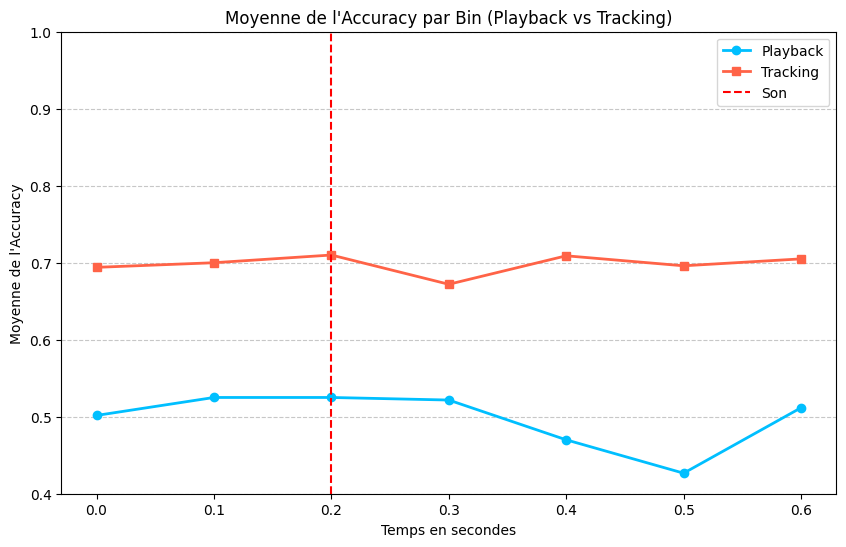

In [8]:
session = 'ALTAI_20240814_SESSION_00'


# Récupérer les données de "playback"
psths_playback, labels_playback, gc = good_blocks(session, 'playback',617)   #[530,730]
res_pbl, mean_accuracies_per_bin_pbl,accuracies_pbl, pbl = KNN(session, 'playback', psths_playback, labels_playback, gc)

# Récupérer les données de "tracking"
psths_tracking, labels_tracking, gc = good_blocks(session, 'tracking',617)
res_tra, mean_accuracies_per_bin_tra, accuracies_tra, tra = KNN(session, 'tracking', psths_tracking, labels_tracking, gc)

# Tracer les courbes de l'accuracy par bin pour "playback" et "tracking"
plt.figure(figsize=(10, 6))

# Courbe pour l'accuracy en "playback"
plt.plot(range(7), mean_accuracies_per_bin_pbl, marker='o', color='deepskyblue', label='Playback', linestyle='-', linewidth=2)

# Courbe pour l'accuracy en "tracking"
plt.plot(range(7), mean_accuracies_per_bin_tra, marker='s', color='tomato', label='Tracking', linestyle='-', linewidth=2)

# Ajouter un titre et des labels
plt.title('Moyenne de l\'Accuracy par Bin (Playback vs Tracking)')
plt.xlabel('Temps en secondes')
plt.ylabel('Moyenne de l\'Accuracy')

# Légende des axes x
plt.xticks(range(7), labels=[f"{i * 0.1:.1f}" for i in range(7)])

# Ajouter une ligne verticale pour indiquer "Son"
plt.axvline(x=2, color='red', linestyle='--', label='Son')

# Définir l'échelle des ordonnées (limites de l'axe y entre 0.4 et 1)
plt.ylim(0.4, 1)

# Ajouter une grille
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter une légende pour distinguer les courbes
plt.legend()

# Afficher le graphique
plt.show()



In [11]:
l1 = [labels_tracking[k][0][0] for k in range(len(labels_tracking))]
d1 = dict(Counter(l1))  #{np.int64(0): 945, np.int64(1): 993} pour le tracking de la session ALTAI_20240822_SESSION_00
print(d1)
l2 = [labels_playback[k][0][0] for k in range(len(labels_playback))]
d2 = dict(Counter(l2))  #{np.int64(0): 945, np.int64(1): 993} pour le tracking de la session ALTAI_20240822_SESSION_00
print(d2)

{np.int64(0): 157, np.int64(1): 297}
{np.int64(0): 133, np.int64(1): 145}


In [12]:
d1[0]

157

In [ ]:
#f = [features[k]['Mock_frequency'] for k in range(len(features)) if features[k]['Block'] == 1 and features[k]['Condition'] == 1]

KeyError: 'Mock_frequency'

In [19]:
print(len(f))

59985


In [13]:
print(len(res))

7


In [17]:
session  = 'ALTAI_20240726_SESSION_01'
path = 'Y:/eTheremin/clara/' + session + '/'
data = np.load(path+'data_ss_0.005.npy', allow_pickle=True)
path_features = 'Z:/eTheremin/ALTAI/' + session + '/headstage_0/'
features = np.load(path_features+'features_0.005.npy', allow_pickle=True)
gc = np.arange(len(data))

In [19]:
count = sum(1 for d in features if 'Mock_frequency' in d) # and 'Mock_change' in d)
count

0

In [29]:
def convert_dict(d):
    """
    Convertit les valeurs d'un dictionnaire en types Python natifs:
    - np.float64 -> int
    - np.False_ / np.True_ -> bool
    """
    # Utilisation de np.vectorize pour rendre les conversions plus rapides et vectorisées
    for key, value in d.items():
        if isinstance(value, np.float64):
            d[key] = int(value)  # Conversion de np.float64 en int
        elif isinstance(value, np.bool_):
            d[key] = bool(value)  # Conversion de np.bool_ en bool
    return d

In [6]:
psth,label = get_psth_in_block(data, features,t_pre, t_post, bin_width, gc, 1,'tracking')

In [7]:
print(len(psth),len(psth[0]),len(psth[0][0]),len(label),len(label[0]),len(label[0][0]))

32 668 140 32 668 2


In [19]:
print(features[0])

{'Played_frequency': np.float64(0.0), 'Condition': np.float64(-1.0), 'Block': np.float64(0.0), 'Frequency_changes': np.False_}


In [12]:
#psths,labels = good_blocks('ALTAI_20240725_SESSION_00','tracking')
print(len(psths),len(psths[0]),len(psths[0][0]),len(labels),len(labels[0]),len(labels[0][0]))

37 918 140 37 918 2


In [ ]:
session = 'ALTAI_20240725_SESSION_00'
path = 'Y:/eTheremin/clara/' + session + '/'
data = np.load(path+'data_ss_0.005.npy', allow_pickle=True)
path_features = 'Z:/eTheremin/ALTAI/' + session + '/headstage_0/'
features = np.load(path_features+'features_0.005.npy', allow_pickle=True)
count_with_mock = 0
indices_without_mock = []

for index, d in enumerate(features):
    if 'Mock_frequency' in d:
        count_with_mock += 1
    else:
        indices_without_mock.append(index)

In [11]:
print(count_with_mock,len(features),len(indices_without_mock))

841911 841911 0


In [ ]:
session = 'ALTAI_20240814_SESSION_00'


# Récupérer les données de "playback"
psths_playback, labels_playback, gc = good_blocks(session, 'playback',617)   #[530,730]
res_pbl, mean_accuracies_per_bin_pbl,accuracies_pbl, pbl = KNN(session, 'playback', psths_playback, labels_playback, gc)

# Récupérer les données de "tracking"
psths_tracking, labels_tracking, gc = good_blocks(session, 'tracking',617)
res_tra, mean_accuracies_per_bin_tra, accuracies_tra, tra = KNN(session, 'tracking', psths_tracking, labels_tracking, gc)

In [29]:
frequences = [[190,256],[296,398],[460,618],[715,960],[1111,1491],[1727,2318],
              [2684,3602],[4172,5599],[6484,8702],[10079,13526],[15667,21025]]


In [34]:
sessions = ['ALTAI_20240822_SESSION_00']
data = []           
for session in sessions:
    for type in ['tracking','playback']:
        for freq in frequences:
            psths,labels,gc,label,label_transpose = good_blocks(session,type,freq)
            if labels != []:
                print(len(label_transpose),len(label_transpose[0]),len(label_transpose[0][0]))
                l1 = [labels[k][0][0] for k in range(len(labels))]
                d1 = dict(Counter(l1))  
                print(d1)
                min_value = min(d1[0],d1[1])
                print(min_value)
                if min_value > 100:
                    res,mean_accuracies_per_bin, accuracies, condition = KNN(session,type,psths,labels,gc)
                    print("res[1]:", res[1])
                    print("res[2]:", res[2])
                    z = (res[1] - 0.5) / res[2]  
                    p_value = 1 - stats.norm.cdf(z) 
                    res.append(p_value)
                    res.append(freq)
                    print(res)
                else :
                    res = [session,None,None,None,type,None,freq]
            else :
                res = [session,None,None,None,type,None,freq]
            data.extend(res)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000018AC5935850>>
Traceback (most recent call last):
  File "c:\Users\Utilisateur\miniconda3\envs\neuro\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [12]:
print(len(label),len(label[0]))

32 0


In [18]:
print(data)

[['ALTAI_20240822_SESSION_00', np.float64(0.5071666666666667), 0, 'tracking'], ['ALTAI_20240822_SESSION_00', np.float64(0.5027222222222223), 1, 'tracking'], ['ALTAI_20240822_SESSION_00', np.float64(0.5154444444444445), 2, 'tracking'], ['ALTAI_20240822_SESSION_00', np.float64(0.5386666666666666), 3, 'tracking'], ['ALTAI_20240822_SESSION_00', np.float64(0.4991666666666667), 4, 'tracking'], ['ALTAI_20240822_SESSION_00', np.float64(0.499), 5, 'tracking'], ['ALTAI_20240822_SESSION_00', np.float64(0.5210555555555555), 6, 'tracking'], ['ALTAI_20240822_SESSION_00', np.float64(0.9924444444444444), 0, 'playback'], ['ALTAI_20240822_SESSION_00', np.float64(0.9924444444444444), 1, 'playback'], ['ALTAI_20240822_SESSION_00', np.float64(0.9924444444444444), 2, 'playback'], ['ALTAI_20240822_SESSION_00', np.float64(0.9924444444444444), 3, 'playback'], ['ALTAI_20240822_SESSION_00', np.float64(0.9924444444444444), 4, 'playback'], ['ALTAI_20240822_SESSION_00', np.float64(0.9924444444444444), 5, 'playback']

In [ ]:
#ar = numpy.array([[1.1, 2, 3.3, 4], [2.7, 10, 5.4, 7], [5.3, 9, 1.5, 15]])
df = pd.DataFrame(data, columns = ['session', 'mean_accuracy', 'std_accuracy','bin','type'])

In [ ]:
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
n = len(accuracies)

# Calculer la valeur z pour la moyenne d'accuracy
z = (mean_accuracy - 0.5) / std_accuracy  # 0.5 est la moyenne sous l'hypothèse nulle

# Calculer la p-value
p_value = 1 - stats.norm.cdf(z)  # P(Z >= z)
confidence_interval = stats.norm.interval(0.95, loc=mean_accuracy, scale=std_accuracy / np.sqrt(n))


print(f"Moyenne de l'accuracy : {mean_accuracy}")
print(f"Écart-type de l'accuracy : {std_accuracy}")
print(f"p-value : {p_value}")
print(f"Intervalle de confiance à 95 % : {confidence_interval}")

<Axes: xlabel='type', ylabel='accuracy'>

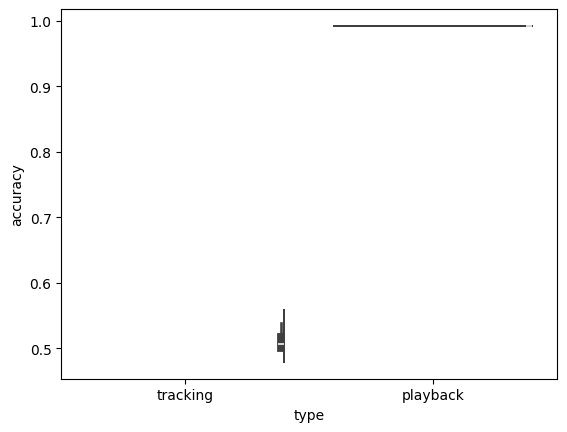

In [20]:
sns.violinplot(data=df, x='type', y='accuracy', split=True)  #hue='bin'